<a href="https://colab.research.google.com/github/vmjs1234/DECISION_TREE_AND_ENSEMBLE/blob/main/7)_gb_ranking_techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.0 MB/s eta 0:00:00


In [3]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score

In [4]:
# Load the dataset (California Housing dataset)
data = fetch_california_housing()
X, y = data.data, data.target

In [5]:
# Convert the target to ranking groups (e.g., based on quantiles)
ranking_groups = pd.qcut(y, q=5, labels=False)
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    X, y, ranking_groups, test_size=0.2, random_state=42
)

In [6]:
# Convert to ranking format
train_group = np.bincount(group_train)
test_group = np.bincount(group_test)

In [7]:
# XGBoost Ranking
import xgboost as xgb

# Define DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define parameters for ranking
params = {
    'objective': 'rank:pairwise',
    'eval_metric': 'ndcg',
    'eta': 0.1,
    'max_depth': 6
}


In [8]:
# Train the model
xgb_model = xgb.train(params, dtrain, num_boost_round=100)

# Predict and evaluate
xgb_preds = xgb_model.predict(dtest)
xgb_ndcg = ndcg_score([y_test], [xgb_preds])
print(f"XGBoost NDCG Score: {xgb_ndcg}")

XGBoost NDCG Score: 0.9701392436944203


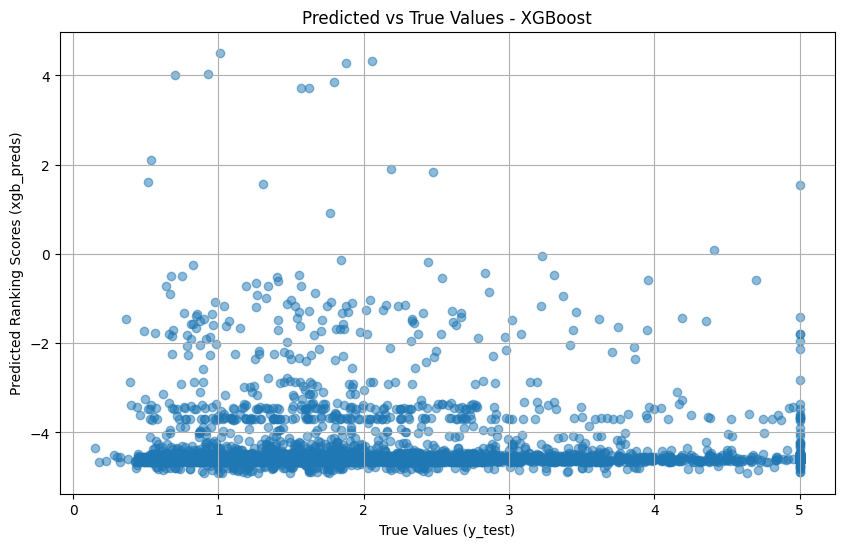

In [33]:


import matplotlib.pyplot as plt

# Assuming xgb_preds contains the predicted ranking scores and y_test contains the true values
# Create a scatter plot to visualize the relationship
plt.figure(figsize=(10, 6))
plt.scatter(y_test, xgb_preds, alpha=0.5)
plt.xlabel("True Values (y_test)")
plt.ylabel("Predicted Ranking Scores (xgb_preds)")
plt.title("Predicted vs True Values - XGBoost")
plt.grid(True)
plt.show()

In [13]:
# LightGBM Ranking
import lightgbm as lgb

# Define the dataset, using ranking_groups as labels instead of y
train_data = lgb.Dataset(X_train, label=group_train, group=train_group) # Changed y_train to group_train
test_data = lgb.Dataset(X_test, label=group_test, group=test_group) # Changed y_test to group_test

# Define parameters
params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'learning_rate': 0.1,
    'num_leaves': 31
}

# Train the model
# The 'early_stopping_rounds' parameter should be inside 'valid_sets'
lgb_model = lgb.train(params, train_data, num_boost_round=100, valid_sets=[test_data])

# Predict and evaluate
lgb_preds = lgb_model.predict(X_test)
lgb_ndcg = ndcg_score([y_test], [lgb_preds]) # Evaluate using original target y_test
print(f"LightGBM NDCG Score: {lgb_ndcg}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

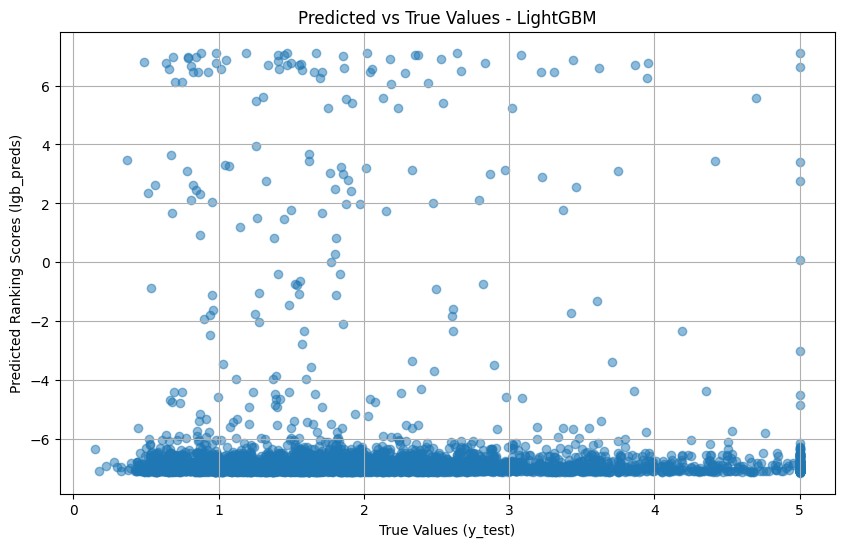

In [35]:

# Assuming lgb_preds contains the predicted ranking scores and y_test contains the true values
# Create a scatter plot to visualize the relationship
plt.figure(figsize=(10, 6))
plt.scatter(y_test, lgb_preds, alpha=0.5)
plt.xlabel("True Values (y_test)")
plt.ylabel("Predicted Ranking Scores (lgb_preds)")
plt.title("Predicted vs True Values - LightGBM")
plt.grid(True)
plt.show()

In [30]:
from catboost import CatBoostRanker, Pool
import numpy as np
import pandas as pd

# Ensure group_train has more than one sample per group
# Get unique groups and their counts
unique_groups, group_counts = np.unique(group_train, return_counts=True)

# Filter out groups with only one sample
valid_groups = unique_groups[group_counts > 1]

# Filter training data to include only valid groups
train_mask = np.isin(group_train, valid_groups)
X_train = X_train[train_mask]
y_train = y_train[train_mask]
group_train = group_train[train_mask]

# Create a DataFrame to sort by group_id
train_df = pd.DataFrame({
    'X': list(X_train),
    'y': y_train,
    'group_id': group_train
})
train_df = train_df.sort_values(by='group_id')

# Extract sorted training data
X_train = np.array(list(train_df['X']))
y_train = np.array(train_df['y'])
group_train_sorted = np.array(train_df['group_id'])

# Create group sizes for training
group_sizes_train = train_df.groupby('group_id').size().tolist()

# Repeat for test data
unique_groups, group_counts = np.unique(group_test, return_counts=True)
valid_groups = unique_groups[group_counts > 1]

test_mask = np.isin(group_test, valid_groups)
X_test = X_test[test_mask]
y_test = y_test[test_mask]
group_test = group_test[test_mask]

# Create a DataFrame to sort by group_id
test_df = pd.DataFrame({
    'X': list(X_test),
    'y': y_test,
    'group_id': group_test
})
test_df = test_df.sort_values(by='group_id')

# Extract sorted testing data
X_test = np.array(list(test_df['X']))
y_test = np.array(test_df['y'])
group_test_sorted = np.array(test_df['group_id'])

# Create group sizes for testing
group_sizes_test = test_df.groupby('group_id').size().tolist()

# Prepare test Pool with group_id array
test_pool = Pool(data=X_test, label=y_test, group_id=group_test_sorted)

# Initialize the CatBoostRanker
cat_model = CatBoostRanker(
    iterations=100,
    learning_rate=0.1,
    depth=6,
    loss_function='YetiRank',
    eval_metric='NDCG'
)

# Train the model with sorted and properly grouped data
cat_model.fit(
    X_train,
    y_train,
    group_id=group_train_sorted,  # Provide group_id array for training
    eval_set=test_pool,  # Pass the test Pool
    verbose=False
)

# Predict and evaluate
cat_preds = cat_model.predict(X_test)
cat_ndcg = ndcg_score([y_test], [cat_preds])
print(f"CatBoost NDCG Score: {cat_ndcg}")



CatBoost NDCG Score: 0.9809460088782899


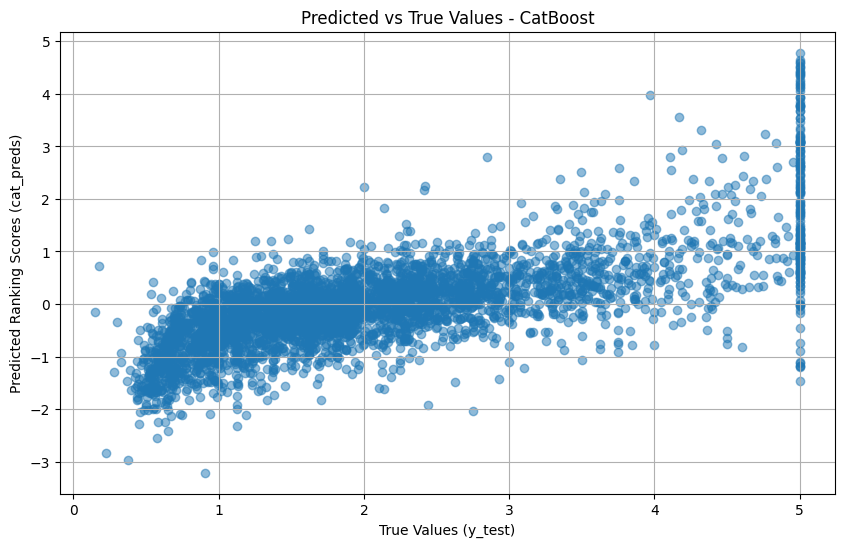

In [36]:
# prompt: plot curve for above catboost

# Assuming cat_preds contains the predicted ranking scores and y_test contains the true values
# Create a scatter plot to visualize the relationship
plt.figure(figsize=(10, 6))
plt.scatter(y_test, cat_preds, alpha=0.5)
plt.xlabel("True Values (y_test)")
plt.ylabel("Predicted Ranking Scores (cat_preds)")
plt.title("Predicted vs True Values - CatBoost")
plt.grid(True)
plt.show()

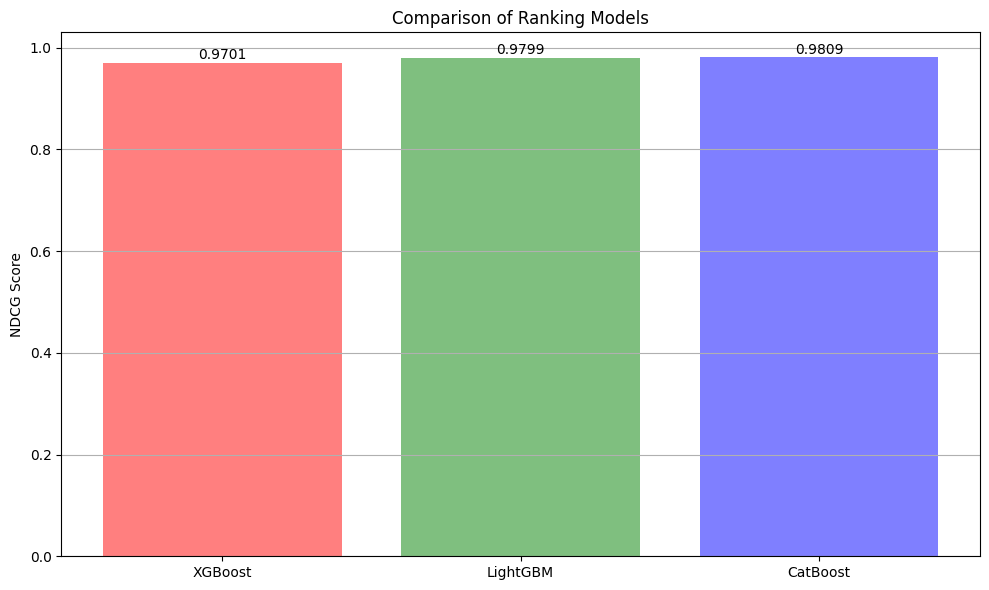

In [32]:


import matplotlib.pyplot as plt
import numpy as np

# Assuming xgb_preds, lgb_preds, and cat_preds are already calculated

# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Define the x-axis values (model names) and y-axis values (NDCG scores)
models = ['XGBoost', 'LightGBM', 'CatBoost']
ndcg_scores = [xgb_ndcg, lgb_ndcg, cat_ndcg]

# Create the bar plot
x_pos = np.arange(len(models))
bars = ax.bar(x_pos, ndcg_scores, align='center', alpha=0.5, color=['red', 'green', 'blue'])

# Annotate the bars with their respective NDCG scores, formatted to two decimal places
for bar, score in zip(bars, ndcg_scores):
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.001, round(score, 4), ha='center', va='bottom')

# Customize the plot
ax.set_ylabel('NDCG Score')
ax.set_title('Comparison of Ranking Models')
ax.set_xticks(x_pos)
ax.set_xticklabels(models)
ax.yaxis.grid(True)

# Show the plot
plt.tight_layout()
plt.show()